In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

In [3]:
def test_print_stat(df, test_col, test='mannwhitneyu'):
    # means of each dist and mann whitney u for each pair
    for s in df.sector_human.unique().tolist():
        print()
        for c in df.sector_conserved.unique().tolist():
            temp = df.loc[(df.sector_human==s)&\
                          (df.sector_conserved==c)].copy(deep=True)
            print(f"Mean of human {s} {c} sector conserved genes: {temp[test_col].mean()}")


    for s in df.sector_human.unique().tolist():
        print()
        for c in df.sector_conserved.unique().tolist():
            temp = df.loc[(df.sector_human==s)&\
                          (df.sector_conserved==c)].copy(deep=True)
            print(f"Median of human {s} {c} sector conserved genes: {temp[test_col].median()}")

    print()
    for s in df.sector_human.unique().tolist():  
        temp = df.loc[df.sector_human==s].copy(deep=True)
        a = temp.loc[temp.sector_conserved==True][test_col].tolist()
        b = temp.loc[temp.sector_conserved==False][test_col].tolist()
        if test=='mannwhitneyu':
            stat, pval = st.mannwhitneyu(a,b,alternative='two-sided')   
            print(f'Mann whitney u human {s} cons vs not cons: {stat}, p={pval}')
        elif test=='ttest_ind':
            stat, pval = st.ttest_ind(a,b,alternative='two-sided')
            print(f'Ttest ind human {s} cons vs not cons: {stat}, p={pval}')

In [4]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [5]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
alu = od+config['ref']['repeats']['alu_bed']
phastcons = od+config['ref']['phastcons100']['txt']


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]
m_cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='mouse')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = od+config['ref']['orth_genes']

mouse_ver = 'vM25_cerberus'

## TES phastcons

pearson r=0.5720401380733038 and pval=0.0
spearman rho=0.545912957144788 and pval=0.0


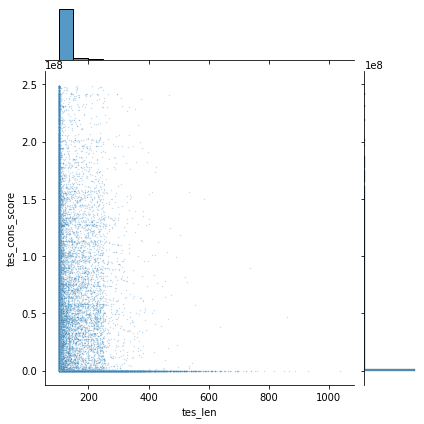

Overall cons.
pearson r=-0.09296392465222174 and pval=0.0
spearman rho=-0.06456574728445144 and pval=6.622293858241877e-172


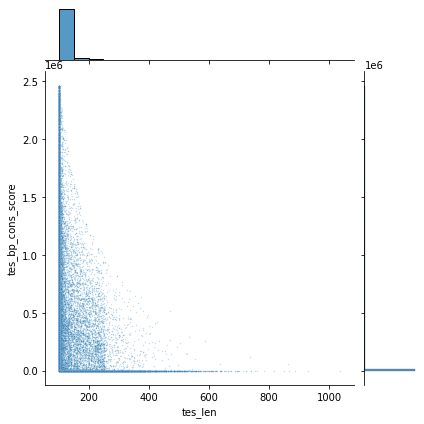

Cons. per BP
pearson r=-0.13175405400014645 and pval=0.0
spearman rho=-0.1518249066692892 and pval=0.0


In [15]:
ca = cerberus.read(cerberus_h5)

df = ca.tes.copy(deep=True)
df['tes_len'] = (df.End-df.Start).abs()
assert len(df.Name.unique()) == len(df.index)
cons = pd.read_csv(phastcons, sep='\t', header=None,
                 names=['bin', 'Chromosome', 'Start', 'End', 'idk1', 'score'])
cons['region_len'] = cons.End-cons.Start
cons['score_bp'] = cons.score/cons.region_len
df = pr.PyRanges(df)
cons = pr.PyRanges(cons)
df = df.join(cons, report_overlap=True, how='left')
df = df.df

# is score related to region len? ( ie is score avg. per bp?)
cons = cons.df
# sns.jointplot(cons, y='score', x='region_len',
#               joint_kws={'s':2, 'alpha':0.25})
# plt.show()

x = cons.score.tolist()
y = cons.region_len.tolist()
r, pval = stats.pearsonr(x, y)
print(f'pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x, y)
print(f'spearman rho={rho} and pval={pval}')

# calc overlap score and sum up the overlapped regions
df['overlap_score'] = df.Overlap*df.score_bp
# ['Chromosome', 'Start', 'End', 'Strand', 'Name', 'source', 'novelty',
       # 'gene_id', 'tes', 'tes_len', 'bin', 'Start_b', 'End_b', 'idk1', 'score',
       # 'region_len', 'score_bp', 'Overlap', 'overlap_score']
df.drop(['Chromosome', 'Start', 'End', 'Strand', 'source',
         'novelty', 'tes', 'score', 'region_len', 'score_bp',
         'Overlap', 'bin', 'idk1', 'Start_b', 'End_b'], axis=1, inplace=True)
df = df.groupby(['Name',
                 'gene_id',
                 'tes_len']).sum().reset_index().rename({'overlap_score':
                                                          'tes_cons_score'}, axis=1)
df['tes_bp_cons_score'] = df['tes_cons_score']/df['tes_len']

# plot correlation between tes len and cons. score, as well as between mean cons score
sns.jointplot(df, y='tes_cons_score', x='tes_len',
              joint_kws={'s':2, 'alpha':0.25})
plt.show()
x = df.tes_cons_score.tolist()
y = df.tes_len.tolist()
r, pval = stats.pearsonr(x, y)
print('Overall cons.')
print(f'pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x, y)
print(f'spearman rho={rho} and pval={pval}')


sns.jointplot(df, y='tes_bp_cons_score', x='tes_len',
              joint_kws={'s':2, 'alpha':0.25})
plt.show()
x = df.tes_bp_cons_score.tolist()
y = df.tes_len.tolist()
r, pval = stats.pearsonr(x, y)
print('Cons. per BP')
print(f'pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x, y)
print(f'spearman rho={rho} and pval={pval}')

df.to_csv('human_tes_cons_score_2.tsv', sep='\t')

## TSS phastcons

pearson r=0.5720401380733038 and pval=0.0
spearman rho=0.545912957144788 and pval=0.0


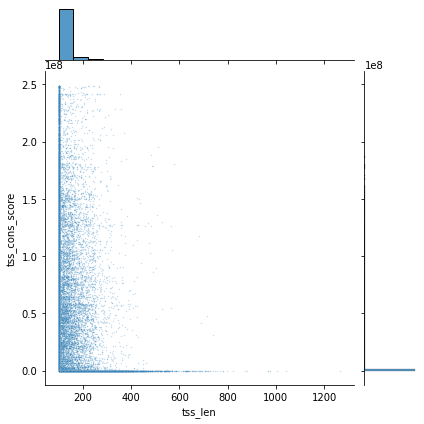

Overall cons.
pearson r=-0.10383800589974221 and pval=0.0
spearman rho=-0.07340761435440168 and pval=1.550350968704067e-185


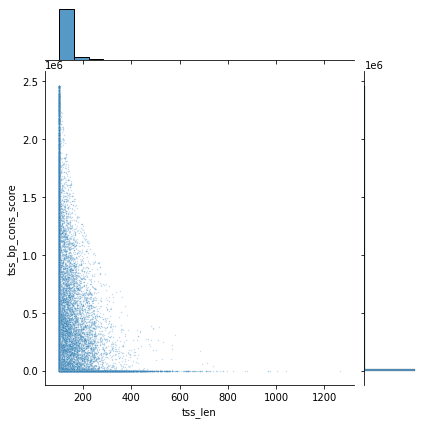

Cons. per BP
pearson r=-0.14661317798123474 and pval=0.0
spearman rho=-0.19707677139874344 and pval=0.0


In [14]:
ca = cerberus.read(cerberus_h5)

df = ca.tss.copy(deep=True)
df['tss_len'] = (df.End-df.Start).abs()
assert len(df.Name.unique()) == len(df.index)
cons = pd.read_csv(phastcons, sep='\t', header=None,
                 names=['bin', 'Chromosome', 'Start', 'End', 'idk1', 'score'])
cons['region_len'] = cons.End-cons.Start
cons['score_bp'] = cons.score/cons.region_len
df = pr.PyRanges(df)
cons = pr.PyRanges(cons)
df = df.join(cons, report_overlap=True, how='left')
df = df.df

# is score related to region len? ( ie is score avg. per bp?)
cons = cons.df
# sns.jointplot(cons, y='score', x='region_len',
#               joint_kws={'s':2, 'alpha':0.25})
# plt.show()

x = cons.score.tolist()
y = cons.region_len.tolist()
r, pval = stats.pearsonr(x, y)
print(f'pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x, y)
print(f'spearman rho={rho} and pval={pval}')

# calc overlap score and sum up the overlapped regions
df['overlap_score'] = df.Overlap*df.score_bp
# ['Chromosome', 'Start', 'End', 'Strand', 'Name', 'source', 'novelty',
       # 'gene_id', 'tss', 'tss_len', 'bin', 'Start_b', 'End_b', 'idk1', 'score',
       # 'region_len', 'score_bp', 'Overlap', 'overlap_score']
df.drop(['Chromosome', 'Start', 'End', 'Strand', 'source',
         'novelty', 'tss', 'score', 'region_len', 'score_bp',
         'Overlap', 'bin', 'idk1', 'Start_b', 'End_b'], axis=1, inplace=True)
df = df.groupby(['Name',
                 'gene_id',
                 'tss_len']).sum().reset_index().rename({'overlap_score':
                                                          'tss_cons_score'}, axis=1)
df['tss_bp_cons_score'] = df['tss_cons_score']/df['tss_len']

# plot correlation between tss len and cons. score, as well as between mean cons score
sns.jointplot(df, y='tss_cons_score', x='tss_len',
              joint_kws={'s':2, 'alpha':0.25})
plt.show()
x = df.tss_cons_score.tolist()
y = df.tss_len.tolist()
r, pval = stats.pearsonr(x, y)
print('Overall cons.')
print(f'pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x, y)
print(f'spearman rho={rho} and pval={pval}')


sns.jointplot(df, y='tss_bp_cons_score', x='tss_len',
              joint_kws={'s':2, 'alpha':0.25})
plt.show()
x = df.tss_bp_cons_score.tolist()
y = df.tss_len.tolist()
r, pval = stats.pearsonr(x, y)
print('Cons. per BP')
print(f'pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x, y)
print(f'spearman rho={rho} and pval={pval}')

df.to_csv('human_tss_cons_score_2.tsv', sep='\t')

## Splice flank scores

In [42]:
def read_cons_table():
    df = pd.read_csv(human_mouse_sect_cons, sep='\t')
    print(len(df.index))
    df['sector_conserved'] = df.sector_human == df.sector_mouse
    df['splicing_conserved']  = (df.sector_human=='splicing')&(df.sector_mouse=='splicing')
    gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist()
    
    # df['cons_cat'] = np.nan

#     # tss
#     df.loc[(df.sector_human=='tss')&\
#            (df.sector_mouse=='tss'), 'cons_cat'] = 'TSS_cons'
#     df.loc[(df.sector_human=='tss')&\
#        (df.sector_mouse!='tss'), 'cons_cat'] = 'TSS_not_cons'
    
#     # splicing
#     df.loc[(df.sector_human=='splicing')&\
#            (df.sector_mouse=='splicing'), 'cons_cat'] = 'Splicing_cons'
#     df.loc[(df.sector_human=='splicing')&\
#        (df.sector_mouse!='splicing'), 'cons_cat'] = 'TSS_not_cons
    return df

13494
Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of isos reported: 209819
209819
175675
im here
1822386
754753
754753
181166
1462694
1461602
1461602
1461602
1461602
13494


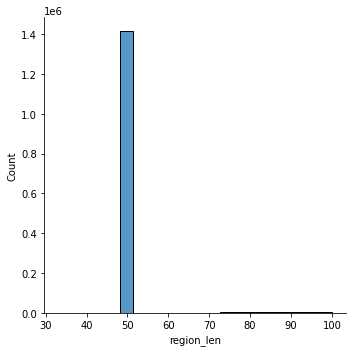

In [44]:
df = read_cons_table()

h_ca = cerberus.read(cerberus_h5)
h_ic = h_ca.ic.loc[h_ca.ic.gene_id.isin(df.gid_human.tolist())]
sj_df, sj_ic_df = get_sj_from_ic(h_ic, ['v29', 'v40'])

# get ids from detected ics from detected transcripts from mouse and human
h_ab = pd.read_csv(filt_ab, sep='\t')
temp, _ = get_tpm_table(h_ab,
               how='iso',
               min_tpm=min_tpm,
               gene_subset='polya', 
               groupby=obs_col)

# limit to mouse match samples
temp = temp[get_mouse_match_samples()]
print(len(temp.index))
temp = temp.loc[temp.any(axis=1)>=min_tpm]
print(len(temp.index))
tids = temp.index.tolist()

temp = pd.DataFrame()
temp['tid'] = tids
temp['ic'] = temp.tid.str.split('[', expand=True)[0]+'_'+\
             temp.tid.str.split('[', expand=True)[1].str.split(',', expand=True)[1]
print('im here')
print(len(sj_ic_df.index))
sj_ic_df = sj_ic_df.loc[sj_ic_df.Name.isin(temp['ic'].tolist())]
print(len(sj_ic_df.index))

sj_ic_df['iid'] = sj_ic_df.Chromosome+'_'+\
                 sj_ic_df.Strand+'_'+\
                 sj_ic_df.Start.astype(str)+'_'+\
                 sj_ic_df.End.astype(str)
sj_ic_df.head()
print(len(sj_ic_df.index))
print(len(sj_ic_df.iid.unique().tolist()))

# convert to PyRanges and get 50 nt upstream and downstream of each sj coordiate
extend = 50
len_min = extend*2
cols = ['Chromosome', 'Strand', 'Start', 'End', 'gene_id', 'Name']
h_df = sj_ic_df[cols].drop_duplicates()

n = len(h_df.index)
temp_h_df = h_df.loc[(h_df.End-h_df.Start)<len_min]
h_df = h_df.loc[~((h_df.End-h_df.Start)<len_min)]
assert len(temp_h_df.index)+len(h_df.index) == n

# introns >= 2*extension length
h_df['flank_5_End'] = h_df.Start+50
h_df['flank_3_Start'] = h_df.End-50
h_df.rename({'Start':'flank_5_Start',
             'End':'flank_3_End'},
            axis=1, inplace=True)
h_df['flank_5'] = h_df['flank_5_Start'].astype(str)+'_'+h_df['flank_5_End'].astype(str)
h_df['flank_3'] = h_df['flank_3_Start'].astype(str)+'_'+h_df['flank_3_End'].astype(str)
h_df.drop(['flank_5_Start', 'flank_5_End', 'flank_3_Start', 'flank_3_End'], axis=1, inplace=True)
h_df = h_df.melt(id_vars=['Chromosome', 'gene_id', 'Name', 'Strand'])
h_df[['Start', 'End']] = h_df.value.str.split('_', expand=True)
h_df['Start'] = h_df['Start'].astype(int)
h_df['End'] = h_df['End'].astype(int)

h_df.drop(['value', 'variable'], axis=1, inplace=True)
# print(h_df.loc[h_df.Name=='ENSG00000122435_1'])


# introns < 2*exension length just get the whole intron
h_df = pd.concat([h_df, temp_h_df], axis=0)

print(len(h_df.index))
h_df = pr.PyRanges(h_df)
h_df = h_df.merge(strand=True,
                  by=['gene_id', 'Name'],
                  count=True)
h_df = h_df.df
print(len(h_df.index))

h_df['region_len'] = h_df.End-h_df.Start
sns.displot(h_df, x='region_len')

h_df_back = h_df.copy(deep=True)
assert len(h_df.loc[(h_df.Count>1)&(h_df.region_len!=100)].index) == 0
h_df.drop('Count', axis=1, inplace=True)

# read phastcons stuff in and merge with human splice flank regions
cons = pd.read_csv(phastcons, sep='\t', header=None,
                 names=['bin', 'Chromosome', 'Start', 'End', 'idk1', 'score'])
cons['region_len'] = cons.End-cons.Start
cons['score_bp'] = cons.score/cons.region_len
cons = cons[['Chromosome', 'Start', 'End', 'score_bp']]
cons = pr.PyRanges(cons)

h_df = h_df_back
h_df['thing'] = h_df.Start.astype(str)+'_'+\
                     h_df.End.astype(str)+'_'+\
                     h_df.Name
print(len(h_df.thing.unique().tolist()))
h_df = pr.PyRanges(h_df)
h_df = h_df.join(cons, report_overlap=True, how='left')
h_df = h_df.df
print(len(h_df.thing.unique().tolist()))

# 0 out the things that do not have any overlap
h_df.loc[h_df.Start_b == -1, ['score', 'Overlap']] = 0
assert len(h_df.loc[(h_df.score == 0)&(h_df.Start_b!=-1)].index) == 0

gb_cols = ['Start', 'End', 'Name', 'region_len']
keep_cols = gb_cols+['region_score']
# h_df['region_score'] = h_df.score*h_df.Overlap
h_df['region_score'] = (h_df.Overlap*h_df.score_bp)/h_df.region_len

h_df.head()
# 1461602
temp = h_df[keep_cols].groupby(gb_cols).sum().reset_index()
temp.head()

print(len(temp.index))

# by ic
temp2 = temp[['Name', 'region_len', 'region_score']].groupby('Name').sum().reset_index()
temp2['score_per_bp'] = temp2['region_score']/temp2['region_len']
temp2.head()

# by gene
temp2['gid'] = temp2['Name'].str.split('_', expand=True)[0]
temp3 = temp2[['gid', 'score_per_bp']].groupby('gid').mean().reset_index().rename({'score_per_bp':'avg_score_per_bp_for_ics'}, axis=1)
temp3

temp3 = temp3.sort_values(by='avg_score_per_bp_for_ics', ascending=False)
temp3.head()

df = read_cons_table()
df = df[['gid_human', 'sector_mouse', 'sector_human']]
df.rename({'gid_human': 'gid'}, axis=1, inplace=True)
df = df.merge(temp3, on='gid', how='inner')
df['sector_conserved'] = df.sector_mouse == df.sector_human



Mean of human tes False sector conserved genes: 0.11462309259310698
Mean of human tes True sector conserved genes: 0.1204003386717746

Mean of human splicing False sector conserved genes: 0.10197963283803567
Mean of human splicing True sector conserved genes: 0.10168470133751444

Mean of human mixed False sector conserved genes: 0.10890590054569868
Mean of human mixed True sector conserved genes: 0.1086798130018978

Mean of human simple False sector conserved genes: 0.10686990194308221
Mean of human simple True sector conserved genes: 0.10528235270699919

Mean of human tss False sector conserved genes: 0.10398676232069023
Mean of human tss True sector conserved genes: 0.10906898769501586

Median of human tes False sector conserved genes: 0.11221677419403661
Median of human tes True sector conserved genes: 0.11920363036582607

Median of human splicing False sector conserved genes: 0.09903117249222829
Median of human splicing True sector conserved genes: 0.09530536674655413

Median of h

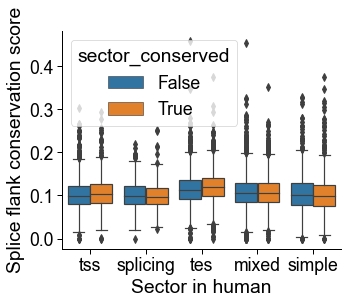

In [48]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.boxplot(df, y='avg_score_per_bp_for_ics', x='sector_human',
                 hue='sector_conserved', order=order)
ax.set(xlabel='Sector in human', ylabel='Splice flank conservation score')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

test_print_stat(df, 'avg_score_per_bp_for_ics', test='mannwhitneyu')